In [1]:
import pandas as pd
import numpy as np
from smart_open import open as s3open
import boto3
import pyspark
from pyspark.context import SparkContext
from pyspark import SQLContext, SparkConf
import preprocessor 
#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize.regexp import RegexpTokenizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import re
import string
from pyspark.sql.types import *

[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# spark version
sc_conf = SparkConf()
sc = SparkContext.getOrCreate();
sc._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3-us-east-1.amazonaws.com')
print(sc.version)

2.4.5-amzn-0


In [3]:
# S3 buchet
s3_path = 's3://aws-logs-506060528669-us-east-1/'
s3 = boto3.resource('s3')
bucket = s3.Bucket('aws-logs-506060528669-us-east-1')

def list_file_in_folder(folder_name):
    lst = []
    if folder_name == '':
        lst.append('')
        for obj in bucket.objects.all():
            lst.append(obj.key.split('/')[0])
            lst = list(set(lst))
    else:
        for obj in bucket.objects.filter(Delimiter='/', Prefix=folder_name+'/'):
            lst.append(obj.key[len(folder_name)+1:])
    return lst[1:]

In [4]:
list_file_in_folder('csv')

['train.csv']

In [ ]:
### READ FROM S3
#
# with s3open(s3_path+'/csv/corona_tweets_01.csv', 'rb') as file:
#    for line in file:
#         print(line.decode('utf8'))
#
# pd.read_csv(s3_path+'csv/corona_tweets_01.csv').to_csv(s3_path+'csv2/corona_tweets_02.csv')

# Train set

In [5]:
train = pd.read_csv(s3_path+'csv/train.csv')

In [6]:
train.head()

,tweet_id,sentiment,text
0,1240727913579896832,1,@MimrotReena @rohanrgupta @priyankagandhi Best...
1,1240728327192604673,1,Awesome! https://t.co/rCwdd0YnDO
2,1240729172139552772,1,Excellent simulator on virus spread https://t....
3,1240729578999402497,1,RT @ankitasood13: Watch this video !! \nWe are...
4,1240729757018279936,1,"Here's the front of @TimesProperty, out tomorr..."


In [7]:
train = train.drop_duplicates(subset=['sentiment','text'])

In [10]:
def text_filtering(text):
    text = preprocessor.clean(text)
    
    text = text.lower()
    
    #stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    #words = [w for w in word_tokens if not w in stop_words]
    words = word_tokens
    
    filter_words = []
    for word in words:
        new_word = re.sub(r'[!$%&"\'-()*+,./:;<=>?@[\]^`{|}~_]+', '', (word))
        if new_word != '':
            filter_words.append(new_word)
    
    words = filter_words

    stopWords = set(stopwords.words('english'))
    filter_words = []
    for w in words:
        if w not in stopWords:
            filter_words.append(w)
            
    ps = PorterStemmer() 
    filter_words2 = []  
    for w in filter_words:
        filter_words2.append(ps.stem(w))
    filter_words3 = list(set(filter_words))
    
    return ' '.join( [w for w in filter_words3 if len(w)>2] )


In [12]:
train['text'] = train['text'].apply(lambda x: text_filtering(x))

In [13]:
train = train[['text','sentiment']]

In [14]:
train = train[train['text'] !='']

In [15]:
train

,text,sentiment
0,govt case corona world handled modi best,1
1,awesome,1
2,excellent virus simulator spread,1
3,management thankful corona fight superb video ...,1
4,corona-related property answers belgravia plus...,1
...,...,...
299746,labour pandemic vandalism shocking going riots...,-1
299763,shocking corona effects,-1
299799,pathetic company pandemic inhuman customersin ...,-1
299852,charles evil globalis prickce rest featuring u...,-1


## From pandas to pyspark dataframe

In [30]:
mySchema = StructType([ StructField("text", StringType(), True),StructField("sentiment", IntegerType(), True)])
df = spark.createDataFrame(train,schema=mySchema)

In [38]:
df.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|govt case corona ...|        1|
|             awesome|        1|
|excellent virus s...|        1|
|management thankf...|        1|
|corona-related pr...|        1|
+--------------------+---------+
only showing top 5 rows



## Split train and val set

In [31]:
train_set, val_set = df.randomSplit([0.8, 0.2])

In [19]:
train_set.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|-11 awesome resea...|        1|
|-12 stacked say d...|        0|
|-12pm researcher ...|        1|
|-12pm researcher ...|        1|
|-132 johns24 win ...|        1|
+--------------------+---------+
only showing top 5 rows



In [104]:
%%time
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Word2Vec



tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])
#word2vec = Word2Vec(inputCol="words",outputCol="features")
#pipeline = Pipeline(stages=[tokenizer, word2vec, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.9096
ROC-AUC: 0.7223
CPU times: user 71.6 ms, sys: 28 ms, total: 99.7 ms
Wall time: 29.7 s


In [105]:
from pyspark.mllib.evaluation import MulticlassMetrics

#select only prediction and label columns
preds_and_labels = predictions.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[8053.  481.  151.]
 [ 502. 6795.  433.]
 [ 175.  406. 6764.]]


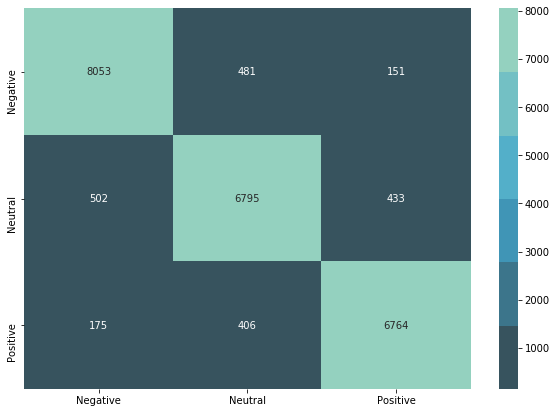

In [121]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics.confusionMatrix().toArray(), index = ['Negative','Neutral','Positive'],
                  columns = ['Negative','Neutral','Positive'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap=sn.color_palette("GnBu_d"),fmt='g')
plt.show()

In [122]:
def label_to_sentiment(string):
    if int(string) == 0:
        return 1
    if int(string) == 1:
        return 0
    if int(string) == 2:
        return -1

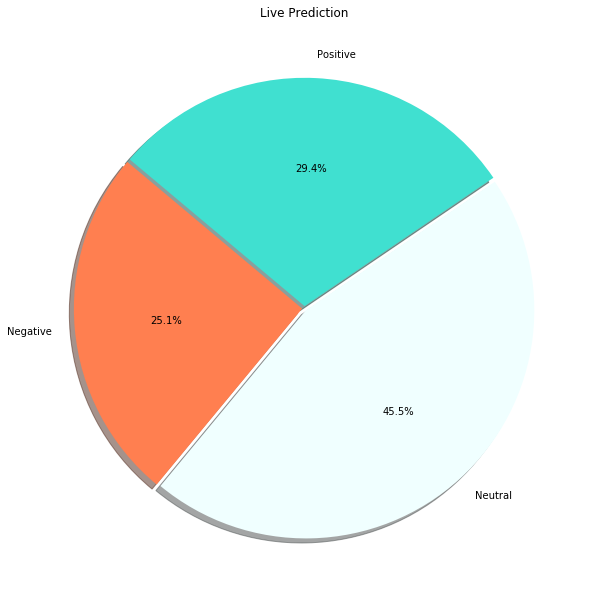

RT @ProjectLincoln: I’m old enough to remember when coronavirus was just another Democrat hoax.

https://t.co/RH1SmGDNJH


In [ ]:
import boto3
import time
import json
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## aws creds are stored in ~/.boto
kinesis = boto3.client("kinesis")
shard_id = "shardId-000000000000" #only one shard!
pre_shard_it = kinesis.get_shard_iterator(StreamName="twitter-data-stream", ShardId=shard_id, ShardIteratorType="LATEST")
shard_it = pre_shard_it["ShardIterator"]

Schema = StructType([ StructField("text", StringType(), True)])

n_1 = 0
n_0 = 0
n_2 = 0
df_results = pd.DataFrame(columns=['text','prediction'])

colors = ['coral', 'azure', 'turquoise']
explode = (0.01, 0.01, 0.01)
labels = ['Negative', 'Neutral', 'Positive']
nums = [0, 0, 0]
n_img = 0

while 1==1:
    out = kinesis.get_records(ShardIterator=shard_it, Limit=1)
    shard_it = out["NextShardIterator"]
    tweet = out['Records'][0]['Data'].decode("utf-8")
    print(tweet)
    text = text_filtering(tweet)
    
    if text != '':
        test_set = spark.createDataFrame(pd.DataFrame([text]),schema=Schema)
        predictions = pipelineFit.transform(test_set)
        record = predictions.select(['text','prediction']).toPandas()
        if record.iloc[0]['prediction'] == 0:
            n_1 += 1
        if record.iloc[0]['prediction'] == 1:
            n_0 += 1
        if record.iloc[0]['prediction'] == 2:
            n_2 += 1
            
        df_results = df_results.append(record, ignore_index=True)
        
        df_results['prediction'].iloc[-1] = label_to_sentiment(df_results['prediction'].iloc[-1])
        df_results['text'].iloc[-1] = tweet
        df_results.to_csv(s3_path+'csv/results.csv', index=False)
        #print(n_1,n_0,n_2)
    
        nums = [n_2,n_0,n_1]
        plt.gca().cla() 
        plt.pie(nums, explode=explode, labels=labels, colors=colors, 
                autopct='%1.1f%%', shadow=True, startangle=140)
        plt.title('Live Prediction')
        with s3open(s3_path+'img/'+str(n_img)+'.png', 'wb') as im:
            plt.savefig(im)
        display.clear_output(wait=True)
        display.display(plt.gcf()) 

        n_img += 1
    time.sleep(1.0)

In [22]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, nb])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.8680
ROC-AUC: 0.5308


In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, gbt])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Py4JJavaError: An error occurred while calling o2040.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 422.0 failed 4 times, most recent failure: Lost task 1.3 in stage 422.0 (TID 812, ip-172-31-7-185.ec2.internal, executor 6): java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 2.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:167)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:165)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1164)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1155)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1090)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1155)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:881)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1405)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2043)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2031)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2030)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2030)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:967)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:967)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:967)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2264)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2213)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2202)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:778)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1213)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:118)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:106)
	at org.apache.spark.ml.regression.DecisionTreeRegressor$$anonfun$train$2.apply(DecisionTreeRegressor.scala:129)
	at org.apache.spark.ml.regression.DecisionTreeRegressor$$anonfun$train$2.apply(DecisionTreeRegressor.scala:124)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:124)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:297)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:55)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1.apply(GBTClassifier.scala:206)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1.apply(GBTClassifier.scala:156)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:156)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 2.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:167)
	at org.apache.spark.ml.classification.GBTClassifier$$anonfun$train$1$$anonfun$1$$anonfun$apply$1.apply(GBTClassifier.scala:165)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1164)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1155)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1090)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1155)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:881)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1405)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier()

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, rf])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

In [ ]:
svm = LinearSVC()